In [ ]:
import os
import datetime
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, recall_score, precision_score
import rampwf as rw
from rampwf.score_types.base import BaseScoreType
from rampwf.score_types.classifier_base import ClassifierBaseScoreType
from rampwf.workflows.sklearn_pipeline import SKLearnPipeline
from rampwf.workflows.sklearn_pipeline import Estimator
# from preprocess import preprocess_df,get_labels
from data_cleaning import preprocess_df#,get_labels

problem_title = "Quality of Air"
data_path = os.path.join("Data", "merged_data.csv")

# -----------------------------------------------------------------------------
# Training / testing data reader
# -----------------------------------------------------------------------------

def get_cv(X, y):
    cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=57)
    return cv.split(X, y)

def _read_data(path, type_):
    
    data = pd.read_csv(data_path, index_col=0, parse_dates=True)

    if type_ == "train":
        data_train,_ = preprocess_df(data)  
        X, y = get_labels(data_train,"PM2.5")
        
    elif type_ == "test":
        _,data_test = preprocess_df(data)
        X, y = get_labels(data_test,"PM2.5")
    
    # for the "quick-test" mode, use less data
    test = os.getenv("RAMP_TEST_MODE", 0)
    if test:
        N_small = 35000
        X = data[:N_small]
        y = y[:N_small]
    
    
    return X,y

def get_train_data(path="."):
    return _read_data(path, "train")


def get_test_data(path="."):
    return _read_data(path, "test")


In [ ]:
X,y = _read_data("Data/merged_data.csv", "train")

C:\Users\angie\Google Drive\Mi unidad\Master\IP\M2\data_camp\Data_camp\data_cleaning.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dateInt"] = (
C:\Users\angie\Google Drive\Mi unidad\Master\IP\M2\data_camp\Data_camp\data_cleaning.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["dateInt"], format="%Y%m%d%H")
C:\Users\angie\Google Drive\Mi unidad\Master\IP\M2\data_camp\Data_camp\data_cleaning.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy o

NameError: name 'get_labels' is not defined

In [ ]:
df = pd.read_csv('Data/train.csv')

In [ ]:
df.head()

,Date-time,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013-03-01,1,2013,3,1,0,4.0,4.0,4.0,7.000000,300.0,77.0,-0.7,1023.0,-18.8,0.0,333.325740,4.4,Aotizhongxin
1,2013-03-01,1,2013,3,1,0,6.0,6.0,4.0,8.000000,300.0,81.0,-0.5,1024.5,-21.4,0.0,333.325740,5.7,Tiantan
2,2013-03-01,1,2013,3,1,0,4.0,4.0,3.0,176.262344,200.0,82.0,-2.3,1020.8,-19.7,0.0,93.787417,0.5,Dingling
3,2013-03-01,1,2013,3,1,0,8.0,8.0,6.0,28.000000,400.0,52.0,-0.7,1023.0,-18.8,0.0,333.325740,4.4,Wanliu
4,2013-03-01,1,2013,3,1,0,3.0,6.0,13.0,7.000000,300.0,85.0,-2.3,1020.8,-19.7,0.0,93.787417,0.5,Changping


In [ ]:
df.shape

(280512, 19)

In [ ]:
df.dtypes

Date-time     object
No             int64
year           int64
month          int64
day            int64
hour           int64
PM2.5        float64
PM10         float64
SO2          float64
NO2          float64
CO           float64
O3           float64
TEMP         float64
PRES         float64
DEWP         float64
RAIN         float64
wd           float64
WSPM         float64
station       object
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280512 entries, 0 to 280511
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date-time  280512 non-null  object 
 1   No         280512 non-null  int64  
 2   year       280512 non-null  int64  
 3   month      280512 non-null  int64  
 4   day        280512 non-null  int64  
 5   hour       280512 non-null  int64  
 6   PM2.5      280512 non-null  float64
 7   PM10       280512 non-null  float64
 8   SO2        280512 non-null  float64
 9   NO2        280512 non-null  float64
 10  CO         280512 non-null  float64
 11  O3         280512 non-null  float64
 12  TEMP       280512 non-null  float64
 13  PRES       280512 non-null  float64
 14  DEWP       280512 non-null  float64
 15  RAIN       280512 non-null  float64
 16  wd         280512 non-null  float64
 17  WSPM       280512 non-null  float64
 18  station    280512 non-null  object 
dtypes: float64(12), int64(5

In [ ]:
df[[col for col in df.columns if col not in ['No', 'year', 'month', 'day', 'hour']]].describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
count,280512.000000,280512.000000,280512.000000,280512.000000,280512.000000,280512.000000,280512.000000,280512.000000,280512.000000,280512.000000,280512.000000,280512.000000
mean,78.176425,105.406720,17.753706,54.274910,1152.813224,60.565993,15.090202,1009.172454,4.016434,0.065810,157.809891,1.680927
std,74.430366,87.207135,23.892452,39.195721,984.356990,57.423377,10.858715,9.937458,13.530829,0.841598,109.321751,1.238769
min,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-14.500000,982.400000,-43.400000,0.000000,7.531307,0.000000
25%,22.000000,39.000000,3.000000,24.000000,500.000000,14.994000,6.000000,1001.300000,-7.100000,0.000000,59.252058,0.900000
50%,57.000000,86.000000,8.000000,45.000000,900.000000,48.000000,16.800000,1008.600000,5.900000,0.000000,147.643642,1.400000
75%,109.000000,147.000000,22.000000,75.000000,1400.000000,86.000000,23.900000,1016.600000,16.000000,0.000000,252.968436,2.200000
max,844.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1038.000000,29.100000,72.500000,333.325740,13.200000


In [ ]:
df['station'].value_counts()

Aotizhongxin     23376
Tiantan          23376
Dingling         23376
Wanliu           23376
Changping        23376
Shunyi           23376
Nongzhanguan     23376
Wanshouxigong    23376
Huairou          23376
Gucheng          23376
Guanyuan         23376
Dongsi           23376
Name: station, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='year', ylabel='PM2.5'>

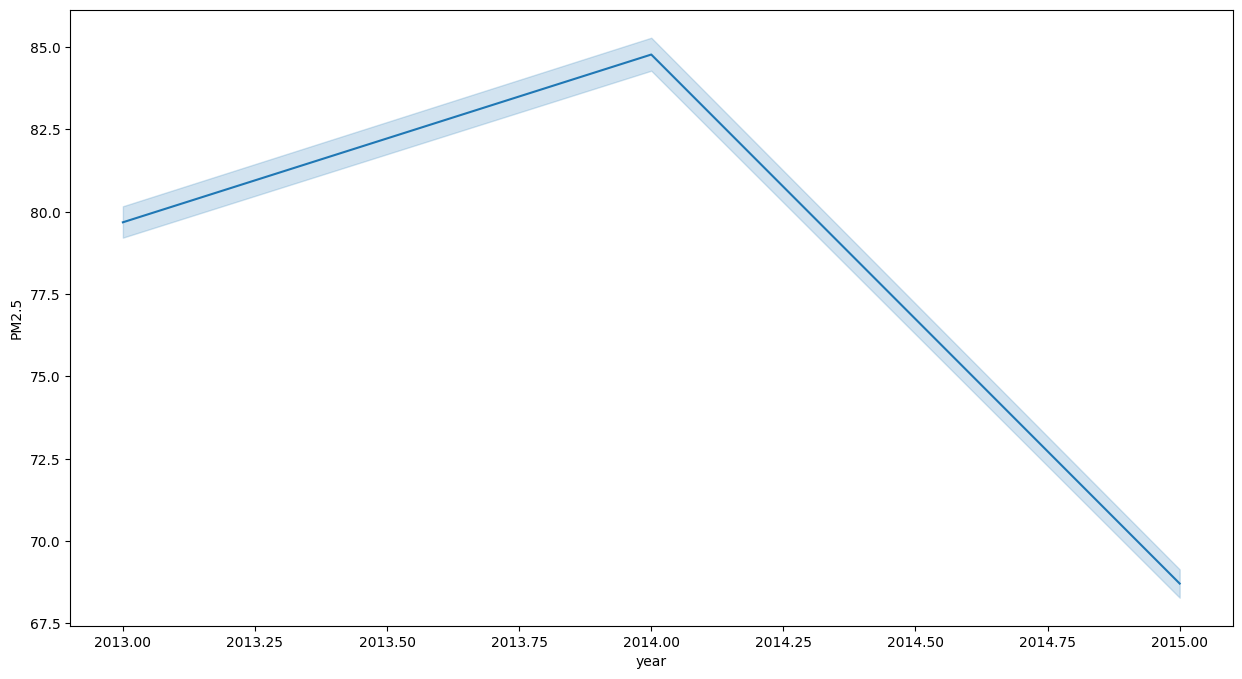

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y='PM2.5',x='year',data=df)

<Axes: xlabel='month', ylabel='PM2.5'>

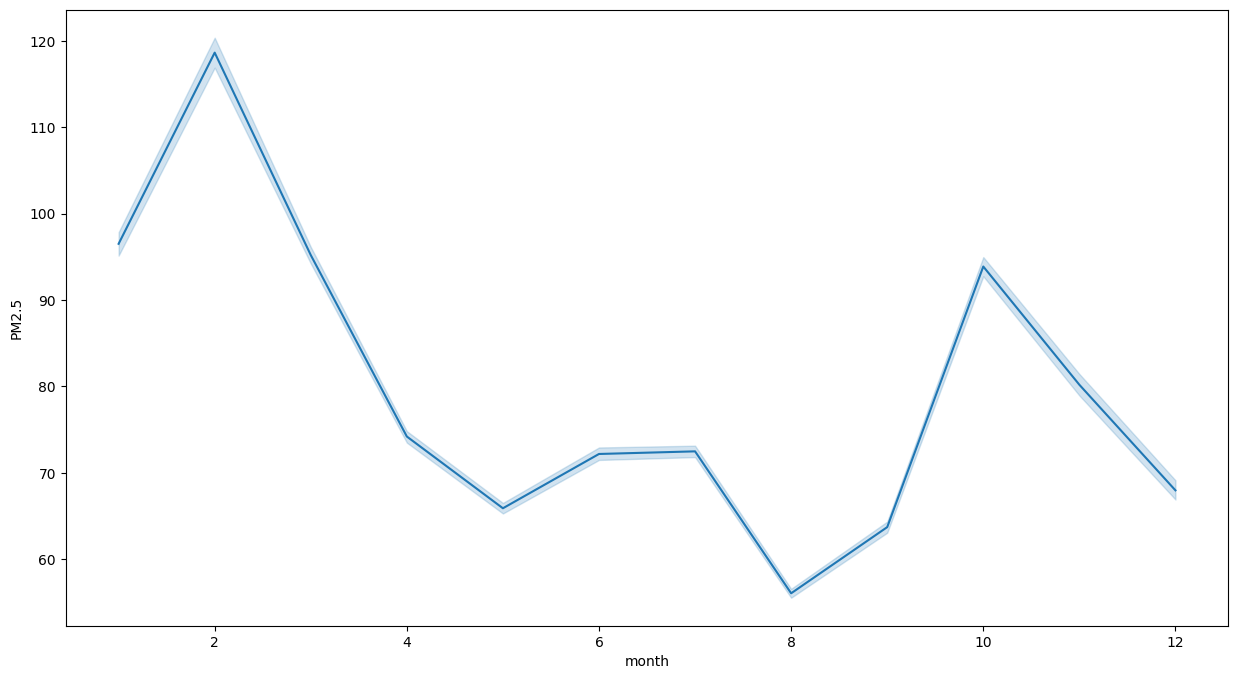

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y='PM2.5',x='month',data=df)

<Axes: xlabel='hour', ylabel='PM2.5'>

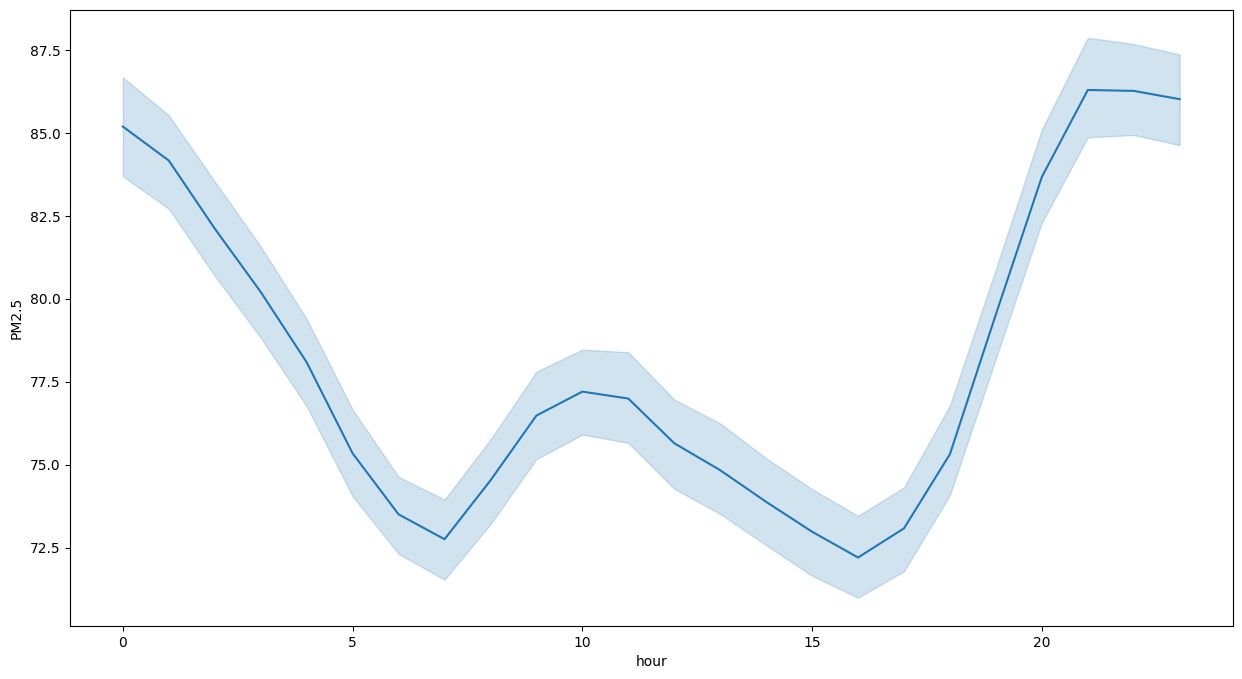

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y='PM2.5',x='hour',data=df)

<Axes: xlabel='year', ylabel='PM2.5'>

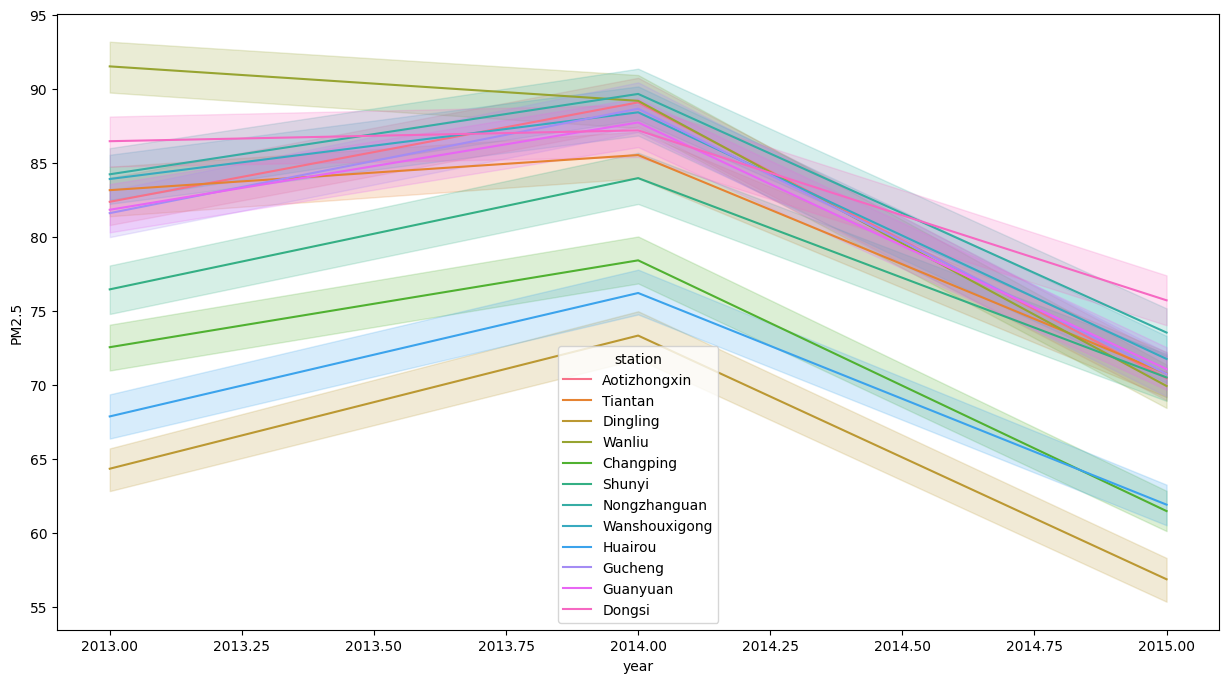

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y='PM2.5',x='year',data=df, hue= 'station')

<Axes: xlabel='month', ylabel='PM2.5'>

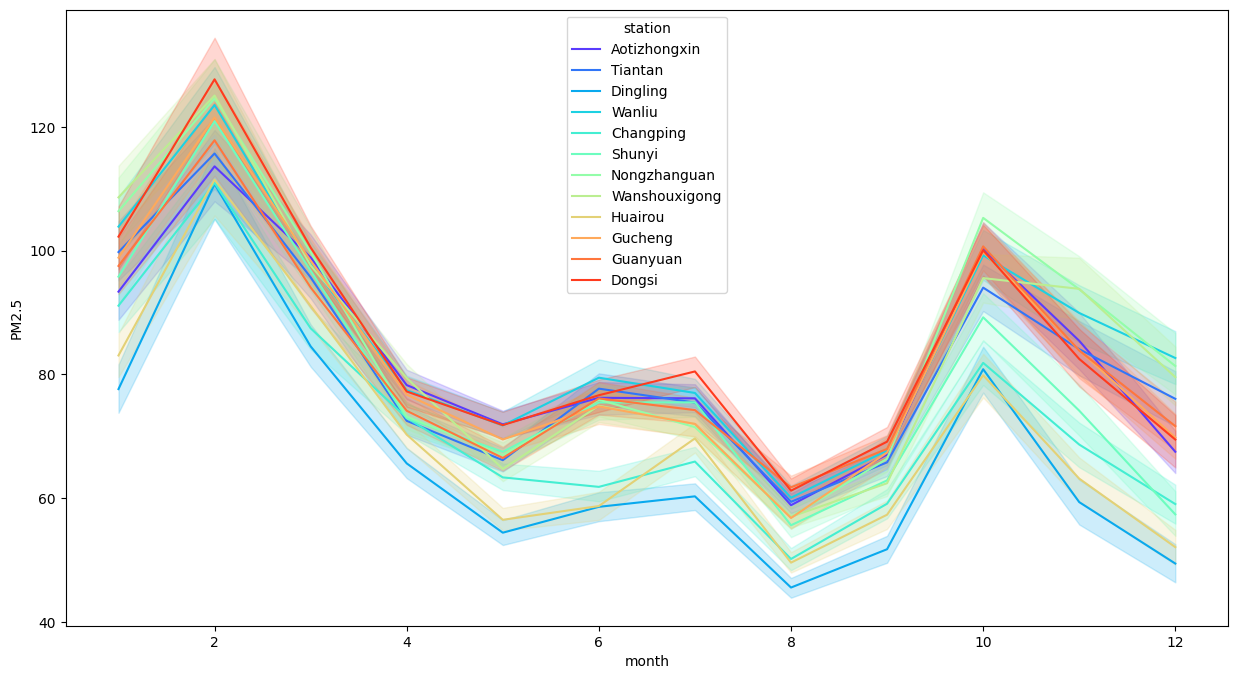

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y='PM2.5',x='month',data=df, hue= 'station', palette='rainbow')

<Axes: xlabel='hour', ylabel='PM2.5'>

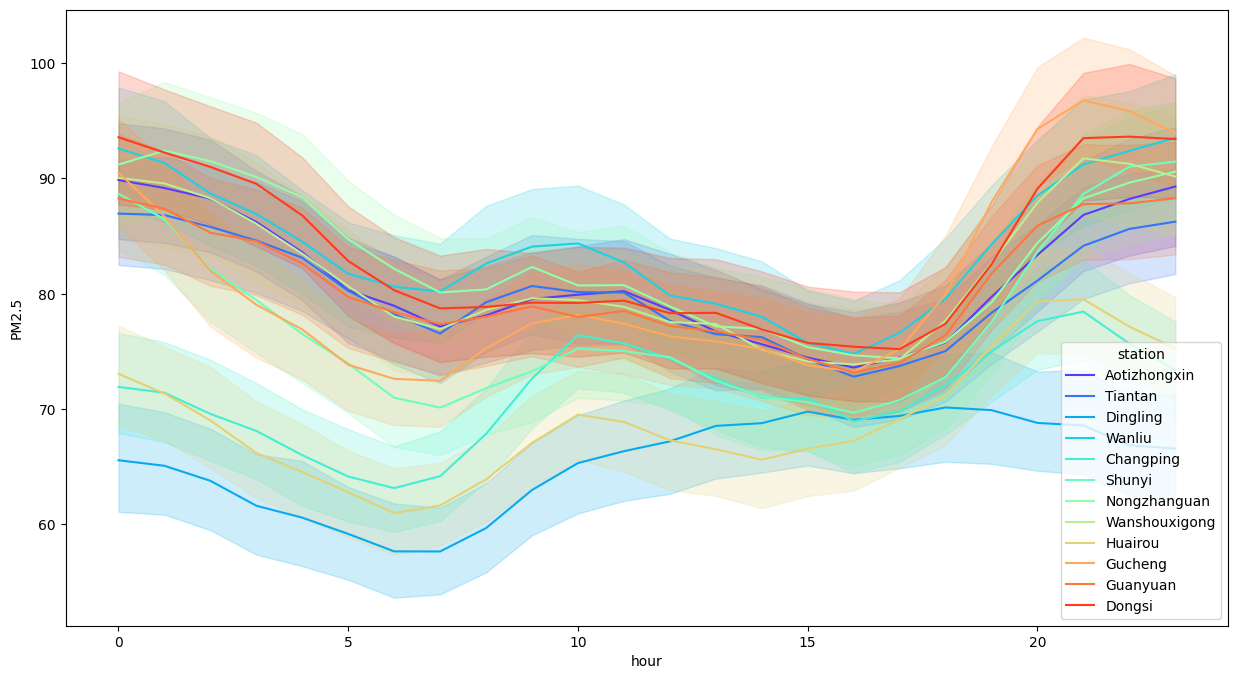

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y='PM2.5',x='hour',data=df, hue= 'station')

## Plotly test

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv('Data/train.csv')

cols = ['year', 'month', 'hour']
fig = go.Figure()
for col in cols:
    df_plot = df[[col, "PM2.5", "station"]].groupby([col, "station"]).mean().reset_index()
    figpx = px.line(df_plot,
        x=col,
        y="PM2.5",
        color = "station",
        hover_name="station").update_traces(visible=False)
    
    fig.add_traces(figpx.data)

fig.update_layout(
    updatemenus=[
        {
            "buttons": 
            [
                {
                    "label": f'{k}',
                    "method": "update",
                    "args": 
                    [
                        {'x': [df[k]]},
                        {'xaxis':{'title':k}},
                        {"visible": k},
                    ],
                }
                for k in cols
            ]
        }        
    ],
).update_traces(visible=True, selector=0)

names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))


# figpx.data[0]['hovertemplate'] = '<b>%{hovertext}</b><br><br>Continent=Europe<br>GDP per capita=%{x}<br>Score=%{y}<br>Population=%{marker.size}<extra></extra>'

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
col = 'month'
px.line(df[[col, "PM2.5", "station"]].groupby([col, "station"]).mean().reset_index(),
        x=col,
        y="PM2.5",
        color = "station",
        hover_name="station")

In [ ]:
# Example
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv("https://media.githubusercontent.com/media/ajgallard/happiness_report/main/data/2018_eng.csv")

cols = df.columns[2:4].values.tolist() # "GDP per Capita" & "Social Support"

fig = go.Figure()
for col in cols:
    figpx = px.scatter(df,
                       x=col,
                       y="Score",
                       size="Population",
                       color="Continent",
                       hover_name="Country/Region",
                       size_max=60,
                       color_discrete_sequence=px.colors.qualitative.G10).update_traces(visible=False)
    
    fig.add_traces(figpx.data)

fig.update_layout(
    updatemenus=[
        {
            "buttons": 
            [
                {
                    "label": f'{k}',
                    "method": "update",
                    "args": 
                    [
                        {'x': [df[k]]},
                        {'xaxis':{'title':k}},
                        {"visible": k},
                    ],
                }
                for k in cols
            ]
        }        
    ]
).update_traces(visible=True, selector=0)

names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))

figpx.data[0]['hovertemplate'] = '<b>%{hovertext}</b><br><br>Continent=Europe<br>GDP per capita=%{x}<br>Score=%{y}<br>Population=%{marker.size}<extra></extra>'

fig.show()